In [2]:
from utils import *

In [8]:
single_samples = 1000
binary_samples = 1000

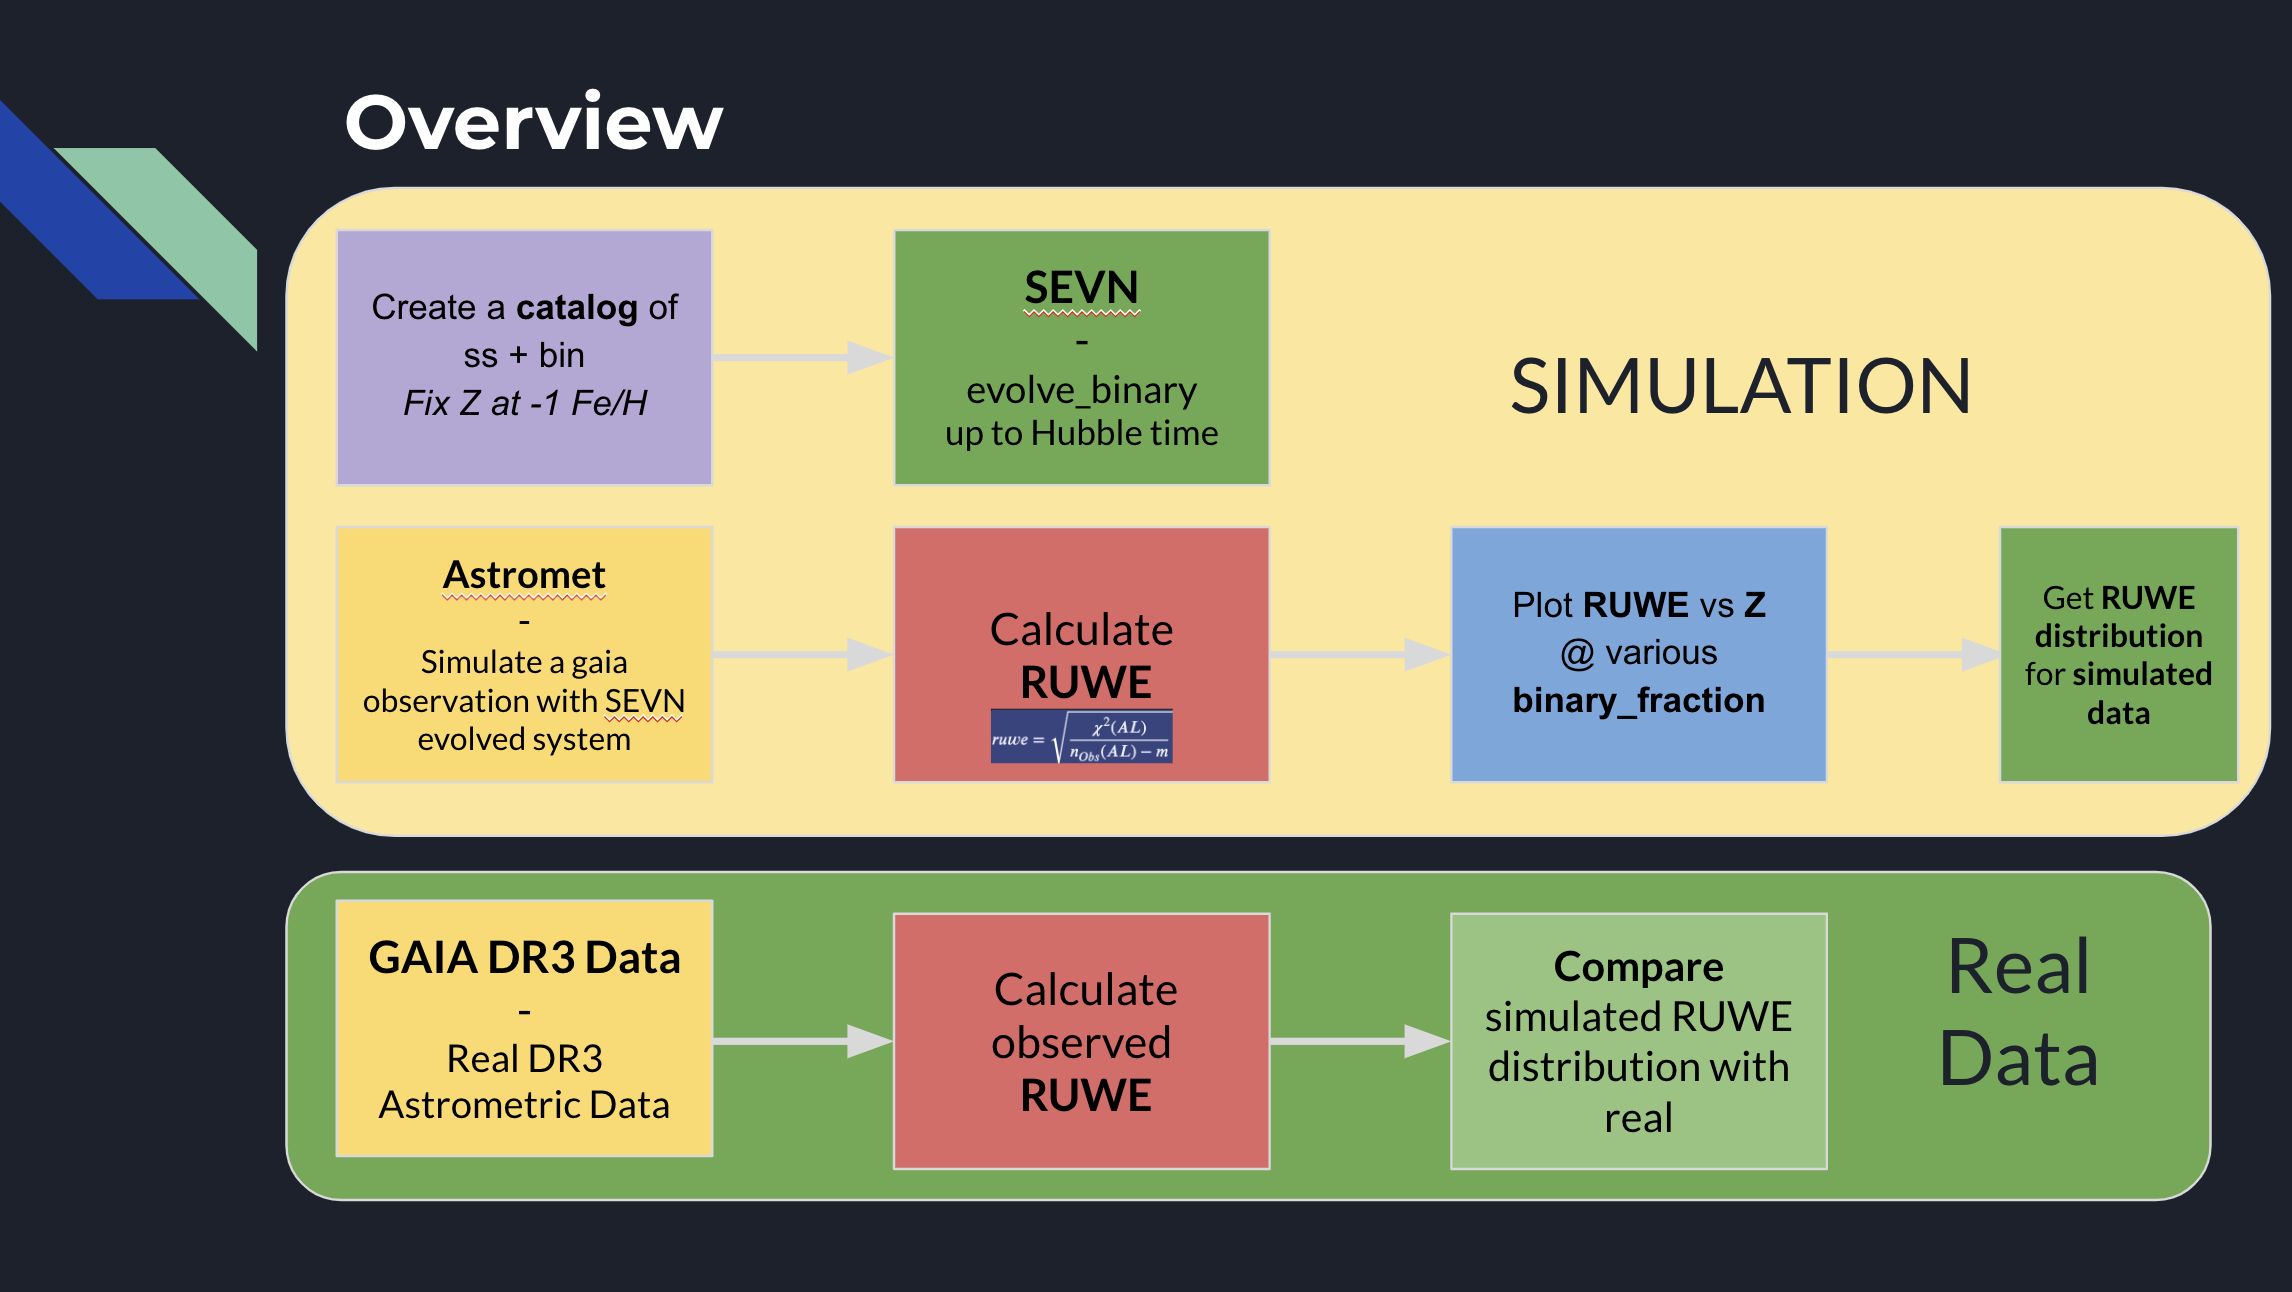

In [9]:
# Display an image from a local file with specified size
img_path = 'images/popsynth.png'
display(Image(filename=img_path, width=1000, height=800))  # Adjust width and height as needed

# Metallicity calculation:

$\frac{[Fe]}{[He]} = \log_{10}\left(\frac{Z}{Z_0}\right)$

where $Z_0 = 0.014$

Fix $\frac{[Fe]}{[He]} = -1$, which corresponds to $ Z = 0.0014$

### **IC4 package**

IC4popsyn is a python module developed for generating the IC for stellar population-synthesis studies. 

In paricular, IC4popsyn includes some of the most used state-of-the-art models (e.g Sana+12) and implements the possibility to generate the IC in the format used by our population synthesis codes (i.e. MOBSE and SEVN).


#### **Default parameters**:
- **alphas**: list of power-law slopes for the initial mass function
- **mass_ranges**: list of mass ranges for the initial mass function
- **logP_min**: minimum logarithm of the period
- **logP_max**: maximum logarithm of the period
- **logP_slope**: slope of the period distribution
- **e_min**: minimum eccentricity
- **e_max**: maximum eccentricity
- **e_slope**: slope of the eccentricity distribution
- **q_min**: minimum mass ratio
- **q_max**: maximum mass ratio
- **q_slope**: slope of the mass ratio distribution
- **mass_min**: minimum mass
- **mass_min_policy**: policy for minimum mass ("qmin" or "mmin")


## Sampling of Binary Star Properties

In the `Binaries` class, the properties of binary stars are sampled as follows:

- **Primary Mass \( m_1 \)**: Drawn from an Initial Mass Function (IMF), reflecting the distribution of star masses.
- **Secondary Mass \( m_2 \)**: Determined by a mass ratio \( q \) (where \( q = m_2/m_1 \)), sampled from a power law distribution, ensuring \( m_2 \) meets specified limits.
- **Orbital Period \( p \)**: Sampled using a power law distribution over a defined range of logarithmic periods, resulting in realistic orbital periods.
- **Eccentricity \( e \)**: Sampled from a power law distribution between defined minimum and maximum values.
- **Semi-Major Axis \( a \)**: Derived from the period \( p \) using Kepler's laws, linking the period and masses to the separation.

### Power Law Definition

A power law describes a relationship where one quantity varies as a power of another, expressed as \( y = kx^n \), where \( k \) is a constant, \( x \) is the variable, and \( n \) is the exponent. This distribution is often used to characterize the frequency of occurrences across various values, such as masses and orbital periods.


A **broken power-law** for the Initial Mass Function (IMF) is a piecewise-defined function where the slope of the power law changes at certain mass thresholds

$\xi(m)$ =

 \begin{cases}
m^{-1.3}, & \text{if } 0.08 \leq m < 0.5 M_\odot \\
m^{-2.3}, & \text{if } 0.5 \leq m < 1 M_\odot \\
m^{-2.3}, & \text{if } m \geq 1 M_\odot
\end{cases}

### **Simulate Nbin binaries with IC4popsyn**

In [10]:
# Constants
G = 6.674e-11  # Gravitational constant in m^3/kg/s^2
M_sun = 1.989e30  # Mass of the sun in kg
AU = 1.496e11  # Astronomical unit in meters
day_to_sec = 86400  # Conversion from days to seconds

def ic_pop_synth(Nbin=100001, backup=1, z=0.0014, system_type=False, mass_ranges=[2.3, 100], 
                            alphas=[-2.3], q_max=4.0, mass_min=2.3, model='sana12', period_units='day'):
    """
    Create a population of binary stars and save the data to a PETAR file.

    Parameters:
    - Nbin: Number of binary systems (default: 100001)
    - backup: Number of backup systems (default: 1)
    - z: Metallicity (default: 0.0014 or [Fe/H] = -1.0)
    - system_type: Type of system to generate (default: False)
    - mass_ranges: List of mass ranges for the initial mass function (default: [0.1,0.5,150])
    - alphas: List of power-law slopes for the initial mass function (default: [-2.3])
    - q_max: Maximum mass ratio (default: 4.0)
    - mass_min: Minimum mass (default: 2.3)
    - model: Model to use for the binary population (default: 'sana12')
    - period_units: Units for the period ('Myr', 'yr', 'day') (default: 'day')
    """
    # Create a population of binaries
    if system_type == False:
        binSana = pop.Binaries(Nbin, single_pop=system_type, model=model, mass_ranges=mass_ranges, 
                           alphas=alphas, q_max=q_max, mass_min=mass_min)
        # Save the population as input for MOBSE
        binSana.save_mobse_input('mobse', z, 13600, backup)

        type1 = [1] * Nbin
        type2 = [1] * Nbin
        tini = [0.0] * Nbin

        # Extract masses and periods from the population
        m1 = binSana.population['m1']  # mass in solar masses
        m2 = binSana.population['m2']  # mass in solar masses
        e = binSana.population['ecc']  # eccentricity

        # Convert periods to the desired units
        if period_units == 'Myr':
            p = binSana.population['p'] / (365.25 * 1e6)  # Convert days to Myr
        elif period_units == 'yr':
            p = binSana.population['p'] / 365.25  # Convert days to years
        elif period_units == 'day':
            p = binSana.population['p'] 
        else:
            raise ValueError("Invalid period_units. Choose from 'Myr', 'yr', or 'day'.")
        
        a = binSana.population['a']

        Z = np.full(Nbin, z)

        # Save to PETAR file with semi-major axis included
        np.savetxt("ic4_" + "binary" + "_" + str(z) + ".in", 
            np.c_[m1, m2, type1, type2, p, e, a, Z, tini],
            fmt="%4.4f %4.4f %i %i %15.9f %1.4f %s %1.4f %1.2f",
            header=str(Nbin - backup), comments='')
    else:
        binSana = pop.Binaries(Nbin, single_pop=system_type, model=model, mass_ranges=mass_ranges, 
                           alphas=alphas)
        
        # Save the population as input for MOBSE
        binSana.save_mobse_input('mobse', z, 13600, backup)

        type1 = [1] * Nbin
        type2 = [1] * Nbin
        tini = [0.0] * Nbin

        # Extract masses and periods from the population
        m1 = binSana.population['m1']  # mass in solar masses

        Z = np.full(Nbin, z)

        # Save to PETAR file with semi-major axis included
        np.savetxt("ic4_" + "single" + "_" + str(z) + ".in", 
            np.c_[m1, type1, type2, Z, tini],
            fmt="%4.4f %i %i %1.4f %1.2f",
            header=str(Nbin - backup), comments='')

In [11]:
binaries = ic_pop_synth(Nbin=single_samples, backup=1, z=0.0014, system_type=False, mass_ranges=[5, 150], 
            alphas=[-2.3], q_max=3.0, mass_min=5, model='sana12', period_units='yr')
singles = ic_pop_synth(Nbin=binary_samples, backup=1, z=0.0014, system_type=True, mass_ranges=[2.3, 150],
            alphas=[-2.3], mass_min=2.3, model='sana12', period_units='yr')

/ |#                                                  | 0 Elapsed Time: 0:00:00
| |#                                                 | 83 Elapsed Time: 0:00:00
/ |#                                                  | 0 Elapsed Time: 0:00:00
| |#                                                  | 0 Elapsed Time: 0:00:00


Building a population of binaries based on Sana+2012 and Kroupa2001
Building a population of binaries based on Sana+2012 and Kroupa2001

Single population print to file only supported for SEVN input style.
Please consider to turn single_pop argument to True.



### **Convert IC files from .in to csvs**

In [12]:
def convert_in_to_csv(input_file, output_file):
    """
    Convert a .in file to a .csv file.

    Parameters:
    input_file (str): Path to the input .in file.
    output_file (str): Path to the output .csv file.
    """
    try:
        # Load the data from the .in file, skipping the first row
        df = pd.read_csv(input_file, sep='\s+', header=None, skiprows=1)

        # Specify column names based on the expected format
        if input_file.startswith('ic4_binary'):
            column_names = ['m1', 'm2', 'type1', 'type2', 'period', 'eccentricity', 'a', 'Z', 'tini']
        elif input_file.startswith('ic4_single'):
            column_names = ['m1', 'type1', 'type2', 'Z', 'tini']
        else:
            column_names = ["name", "m1", "m2", "period", "eccentricity", "Z", "tmax"]
        
        # Ensure the number of columns matches
        df.columns = column_names[:df.shape[1]]  # Only set columns that exist

        # Save the DataFrame to a .csv file
        df.to_csv(output_file, index=False)

        print(f"Conversion successful! Saved as {output_file}")

    except Exception as e:
        print(f"Error reading the file: {e}")

In [13]:
def process_binary_population(z, system_type):
    """
    Process a binary population file and add a binary_id column.

    Parameters:
    - z: Metallicity
    - system_type: Type of the system (e.g., "binary", "single")
    """
    # Use the variable in the function calls and file names
    input_file = f"ic4_{system_type}_{z}.in"
    output_file = f"ic4_{system_type}_{z}.csv"

    convert_in_to_csv(input_file, output_file)

    ic_df = pd.read_csv(output_file)

    # add a column to df_petar for binary_id equal to the index place it at the beginning
    ic_df.insert(0, str(system_type)+"_id", range(0, 0 + len(ic_df)))

    return ic_df

z = 0.0014
system_type = "binary"
ic_binary = process_binary_population(z, system_type)

z = 0.0014
system_type = "single"
ic_single = process_binary_population(z, system_type)


Conversion successful! Saved as ic4_binary_0.0014.csv
Conversion successful! Saved as ic4_single_0.0014.csv


### **Evolve Binaries with SEVN**

In [14]:
def run_sevn_simulations(IC_df, num_rows=10, system_type="binary", t_end=1.35e5, snmodel="delayed", rseed=0, num_binary=101):
    """
    Run SEVN simulations for a binary star population.

    Parameters:
    - csv_file: Path to the CSV file containing the binary star population data (default: "petar_0.2.csv")
    - num_rows: Number of rows to read from the CSV file (default: 10)
    - t_end: End time for the SEVN evolution (default: Hubble time in Myr)
    - snmodel: Supernova model to use (default: "delayed")
    - rseed: Random seed for reproducibility (default: 0)
    """
    SEVNmanager.init()
    
    # Read the CSV file
    df = IC_df.head(num_rows)

    if system_type == "binary":
        binary_ids = df['binary_id']

        # Initialize an empty DataFrame to store results
        results_df = pd.DataFrame()

        # Loop over the arrays with tqdm progress bar
        for i in tqdm(range(0,num_rows), desc="Running SEVN simulations"):
            output, log = sevnwrap.evolve_binary(Semimajor=df['a'][i],
                                                Eccentricity=df['eccentricity'][i],
                                                Mzams_0=df['m1'][i],
                                                Z_0=df['Z'][i],
                                                Mzams_1=df['m2'][i],
                                                Z_1=df['Z'][i],
                                                tend=int(t_end),
                                                snmodel=snmodel,  # SN model to use, see the SEVN userguide
                                                rseed=rseed  # Random seed for reproducibility, if 0 or not included a random value will be generated
            ) 

            # Convert output to DataFrame and append binary_id
            output_df = pd.DataFrame(output)
            output_df['binary_id'] = binary_ids[i]
            results_df = pd.concat([results_df, output_df], ignore_index=True)
            results_df['system_type'] = 2


    else:

        single_ids = df['single_id']
        # Initialize an empty DataFrame to store results
        results_df = pd.DataFrame()

        # Loop over the arrays with tqdm progress bar
        for i in tqdm(range(0, num_rows), desc="Running SEVN simulations"):
            single_star = Star(df['m1'][i], df['Z'][i])
            single_star.evolve(tend=t_end)
            evolved_single = single_star.evolve_table
            evolved_single['single_id'] = single_ids[i] + num_binary
            results_df = pd.concat([results_df, evolved_single], ignore_index=True)
            results_df['system_type'] = 1

    # Close SEVN manager
    SEVNmanager.close()

    return results_df

In [15]:
evolved_binaries = run_sevn_simulations(ic_binary, num_rows=binary_samples, system_type="binary", t_end=1.35e5, snmodel="delayed", rseed=0)
evolved_singles = run_sevn_simulations(ic_single, num_rows=single_samples, system_type="single", t_end=1.35e5, snmodel="delayed", rseed=0, num_binary=binary_samples)

Running SEVN simulations: 100%|██████████| 1000/1000 [00:15<00:00, 65.58it/s]


In [17]:
# # save the evolved binaries and singles to csv files
# evolved_binaries.to_csv("evolved_binaries.csv", index=False)
# evolved_singles.to_csv("evolved_singles.csv", index=False)

# # read the evolved binaries and singles csv files
# evolved_binaries = pd.read_csv("evolved_binaries.csv")
# evolved_singles = pd.read_csv("evolved_singles.csv")

In [18]:
evolved_singles.rename(columns={"Localtime": "Localtime_0", "Mass": "Mass_0", "Radius": "Radius_0", "Inertia": "Inertia_0",
                                "Luminosity": "Luminosity_0", "Temperature": "Temperature_0", "MHE": "MHE_0", "MCO": "MCO_0",
                                "RHE": "RHE_0", "RCO": "RCO_0", "Phase": "Phase_0", "RemnantType": "RemnantType_0",
                                "PhaseBSE": "PhaseBSE_0", "Spin": "Spin_0", "Ebind": "Ebind_0", "Zams": "Zams_0",
                                "Event": "Event_0", "dMRLOdt": "dMRLOdt_0", "dMaccwinddt": "dMaccwinddt_0",
                                "Plife": "Plife_0", "single_id": "id"}, inplace=True)

evolved_binaries.rename(columns={"binary_id": "id"}, inplace=True)

# merge the two dataframes
popsynth_df = pd.concat([evolved_binaries, evolved_singles])

### **Use astromet + SEVN distributions to mock GAIA observations**

4) Use those parameters distributions as input to astromet

5) Calculate simulated RUWE and rv error  

Question - I am calculating the ruwe using the astrometric_chi2_al, astrometric_n_good_obs_al and astrometric_params_solved, I am getting a large astrometric_chi2_al calculated by R represents the residuals of the fit. Residuals are the differences between the observed values and the values predicted by the model.

6) Plot RUWE vs rv error color coded by remnant type

### Load ScanLaw file

It loads the scanning law times from the CSV file 

In [19]:
# /Gaia/gedr3/auxiliary/commanded_scan_law/ @ https://cdn.gea.esac.esa.int/Gaia/gedr3/auxiliary/commanded_scan_law/
local_csv_filename = "data/cog/CommandedScanLaw_001.csv"

# Load the scanning law times from a local CSV file with the specified filename and version
dr3_sl = scanninglaw.times.Times(map_fname=local_csv_filename, version='dr3_nominal')

Loading auxilliary data ...
t = 34.341 s
  auxilliary:  20.755 s
          sf:   6.094 s
interpolator:   7.491 s


### **Calculate q, l and log_sg**

In [20]:
# using evolved_binaries dataframe calculate the mass ratio q and luminosity ratio l
popsynth_df['q'] = popsynth_df['Mass_1'] / popsynth_df['Mass_0']
popsynth_df['l'] = popsynth_df['Luminosity_1'] / popsynth_df['Luminosity_0']
popsynth_df['log_sg_0'] = np.log10(G * popsynth_df['Mass_0'])/((popsynth_df['Radius_0'])**2)
popsynth_df['log_sg_1'] = np.log10(G * popsynth_df['Mass_1'])/((popsynth_df['Radius_1'])**2)

In [21]:
# show me all the columns
pd.set_option('display.max_columns', None)
# show me the first 5 rows
popsynth_df.head()

,Worldtime,Semimajor,Eccentricity,Period,RL0,RL1,GWtime,BEvent,Localtime_0,Localtime_1,Mass_0,Mass_1,Radius_0,Radius_1,Inertia_0,Inertia_1,Luminosity_0,Luminosity_1,Temperature_0,Temperature_1,MHE_0,MHE_1,MCO_0,MCO_1,RHE_0,RHE_1,RCO_0,RCO_1,Phase_0,Phase_1,RemnantType_0,RemnantType_1,PhaseBSE_0,PhaseBSE_1,Spin_0,Spin_1,Ebind_0,Ebind_1,Zams_0,Zams_1,Event_0,Event_1,dMRLOdt_0,dMRLOdt_1,dMaccwinddt_0,dMaccwinddt_1,Plife_0,Plife_1,id,system_type,q,l,log_sg_0,log_sg_1
0,0.000000,24.641195,0.311900,0.006216,7.492828,11.303139,3156.113050,-1.0,0.470831,0.149811,11.230305,27.710798,3.160495,5.433424,11.217645,81.808093,8742.045647,97972.286889,31394.408966,43809.226092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.000000,0.000000,0.0,0.0,11.2304,27.7141,-1.0,-1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,2,2.467502,11.207021,-0.913552,-0.295811
1,0.037334,24.107664,0.298440,0.006016,7.330660,11.058329,2987.374488,3.0,0.508165,0.187144,11.230325,27.709885,3.165662,5.449623,11.254376,82.293890,8753.725856,98364.347115,31379.249247,43787.766276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.004693,0.077536,0.0,0.0,11.2304,27.7141,-1.0,-1.0,0.0,0.0,0.000737,0.000049,0.002065,0.006021,0,2,2.467416,11.236855,-0.910572,-0.294056
2,0.078724,23.574142,0.283953,0.005817,7.168497,10.813518,2823.884323,-1.0,0.549555,0.228534,11.230349,27.708873,3.171400,5.467637,11.295238,82.835834,8766.693190,98800.833032,31362.451205,43763.987453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.010554,0.155891,0.0,0.0,11.2304,27.7141,-1.0,-1.0,0.0,0.0,0.000756,0.000050,0.004354,0.012697,0,2,2.467321,11.270023,-0.907280,-0.292122
3,0.119287,23.128126,0.270546,0.005653,7.032940,10.608852,2693.345471,-1.0,0.590118,0.269098,11.230373,27.707881,3.177034,5.485350,11.335430,83.370423,8779.420325,99230.485597,31345.997188,43740.695801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.017010,0.220849,0.0,0.0,11.2304,27.7141,-1.0,-1.0,0.0,0.0,0.000775,0.000051,0.006598,0.019239,0,2,2.467227,11.302624,-0.904065,-0.290239
4,0.160214,22.761041,0.258019,0.005519,6.921383,10.440392,2592.239733,-1.0,0.631045,0.310025,11.230398,27.706880,3.182729,5.503280,11.376127,83.913298,8792.280212,99665.881207,31329.404502,43717.208034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.024149,0.272188,0.0,0.0,11.2304,27.7141,-1.0,-1.0,0.0,0.0,0.000792,0.000052,0.008862,0.025840,0,2,2.467132,11.335612,-0.900832,-0.288351


In [22]:
def filter_last_row(df):
    """
    Filter the DataFrame to keep the last row for each id based on the system_type.
    
    Parameters:
    - df: Original DataFrame containing the 'id' and 'system_type' columns.
    
    Returns:
    - A new DataFrame with the filtered rows.
    """
    def custom_filter(group):
        if group['system_type'].iloc[-1] == 1:
            return group.iloc[[-1]]
        elif group['system_type'].iloc[-1] == 2:
            return group.dropna(subset=['Mass_0', 'Mass_1']).iloc[[-1]]
        else:
            return pd.DataFrame()

    # Group by 'id' and apply the custom filter
    filtered_df = df.groupby('id').apply(custom_filter).reset_index(drop=True)
    
    return filtered_df

# Example usage
popsynth_df = filter_last_row(popsynth_df)

/tmp/ipykernel_52089/239220372.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = df.groupby('id').apply(custom_filter).reset_index(drop=True)


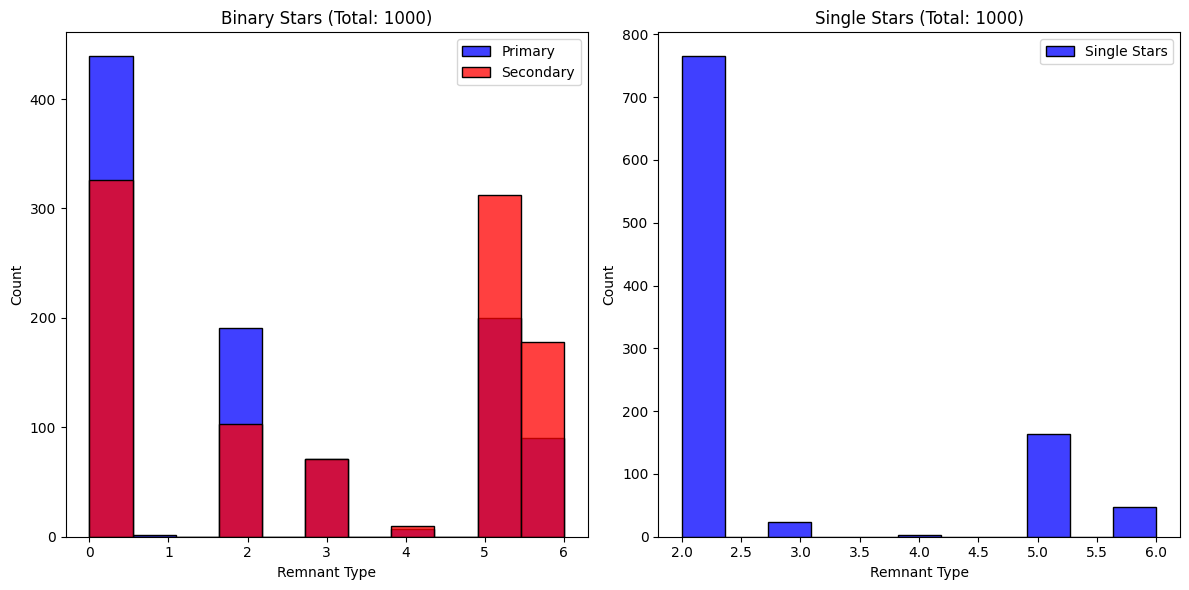

In [23]:
# Calculate the total counts
binary_count = len(popsynth_df[popsynth_df['system_type'] == 2])
single_count = len(popsynth_df[popsynth_df['system_type'] == 1])

# Plot the distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for binary stars
sns.histplot(popsynth_df[popsynth_df['system_type'] == 2]['RemnantType_0'], ax=ax[0], color='blue', label='Primary')
sns.histplot(popsynth_df[popsynth_df['system_type'] == 2]['RemnantType_1'], ax=ax[0], color='red', label='Secondary')
ax[0].set_title(f'Binary Stars (Total: {binary_count})')
ax[0].set_xlabel('Remnant Type')
ax[0].set_ylabel('Count')
ax[0].legend()

# Plot for single stars
sns.histplot(popsynth_df[popsynth_df['system_type'] == 1]['RemnantType_0'], ax=ax[1], color='blue', label='Single Stars')
ax[1].set_title(f'Single Stars (Total: {single_count})')
ax[1].set_xlabel('Remnant Type')
ax[1].set_ylabel('Count')
ax[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

###### Parallax is a measure of the apparent shift in position of a star due to the Earth's movement around the Sun and is typically measured in milliarcseconds (mas). Not calculated, sampled from a distribution in astromet

### 1) Drop all NaN values represeting the "disintegration" of the binary given a SN or other event
### 2) Keep only the last row of that star representing it's end of the evolution cycle
### 3) Set binary id as index

In [24]:
# make the id the index
popsynth_df = popsynth_df.set_index('id')

### Simulate a **Gaia Observation** with astromet and calculate **RUWE**

- RUWE ≈ 1: The astrometric model (single-star model) fits the data well, meaning that the observed motion and position of the object align with what is expected for a single star.

- RUWE > 1.4: A value higher than 1.4 may indicate a poor fit, suggesting the object could be more complex (e.g., a binary star system, or something else affecting the motion or position).

- Lower values (~1): Generally considered to indicate a good fit.

# Astrometric Parameters

Descriptions of key astrometric parameters used in astronomical observations, such as in the Gaia mission. These parameters describe the position and motion of celestial objects.

## Astrometric Parameters

### 1. Right Ascension (RA) – `params.ra`
Right Ascension (RA) defines the east-west position of an object on the celestial sphere, analogous to longitude on Earth. It is measured in hours, minutes, and seconds, ranging from 0 to 24 hours.

### 2. Declination (Dec) – `params.dec`
Declination (Dec) defines the north-south position of an object on the celestial sphere, analogous to latitude. It is measured in degrees, with values ranging from -90° to +90°, where 0° is the celestial equator.

### 3. Parallax – `params.parallax`
Parallax is the apparent shift in the position of a star due to Earth's motion around the Sun, measured in arcseconds. It is used to determine the distance to nearby stars, where distance (in parsecs) is the inverse of the parallax.

### 4. Proper Motion in RA (PMRA) – `params.pmrac`
Proper Motion in Right Ascension (PMRA) describes a star's east-west motion across the sky, scaled by the cosine of the Declination to account for spherical geometry. It is measured in milliarcseconds per year (mas/yr).

### 5. Proper Motion in Dec (PMDec) – `params.pmdec`
Proper Motion in Declination (PMDec) describes a star's north-south motion across the sky, also measured in milliarcseconds per year (mas/yr).

## Conclusion
These astrometric parameters are essential for mapping the position and motion of celestial objects, helping astronomers understand their dynamics and distances.

In [25]:
popsynth_df

,Worldtime,Semimajor,Eccentricity,Period,RL0,RL1,GWtime,BEvent,Localtime_0,Localtime_1,Mass_0,Mass_1,Radius_0,Radius_1,Inertia_0,Inertia_1,Luminosity_0,Luminosity_1,Temperature_0,Temperature_1,MHE_0,MHE_1,MCO_0,MCO_1,RHE_0,RHE_1,RCO_0,RCO_1,Phase_0,Phase_1,RemnantType_0,RemnantType_1,PhaseBSE_0,PhaseBSE_1,Spin_0,Spin_1,Ebind_0,Ebind_1,Zams_0,Zams_1,Event_0,Event_1,dMRLOdt_0,dMRLOdt_1,dMaccwinddt_0,dMaccwinddt_1,Plife_0,Plife_1,system_type,q,l,log_sg_0,log_sg_1
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.612497,11.785717,0.000000,0.002109,3.853017,5.106396,2.513038e+02,-1.0,4.989083,6.508626,12.964288,24.039074,4.020123,11.806076,2.095209e+01,3.350649e+02,1.647750e+04,1.566659e+05,32615.928357,33420.845723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.719666,1.000000,0.0,0.0,12.965662,24.266903,-1.0,-1.0,15.83421,-31.66842,0.004103,0.000218,0.311486,0.903778,2,1.854253,9.507871,-5.607727e-01,-6.309714e-02
1,135000.000000,58.907226,0.022277,0.106049,22.139091,22.503693,1.182428e+09,-1.0,134932.811834,134939.053738,0.897711,0.930385,0.009204,0.008838,3.041857e-05,2.907104e-05,1.803732e-07,1.869260e-07,1239.892532,1276.613733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,2.0,2.0,11.0,11.0,0.000000,0.999995,0.0,0.0,1.042891,1.042891,-1.0,-1.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,2,1.036396,1.036329,-1.206741e+05,-1.306646e+05
2,0.000000,45.553001,0.766300,0.008734,13.578948,21.206694,7.763709e+01,-1.0,0.119166,0.059287,34.010379,90.619237,6.073974,10.419009,1.254750e+02,9.837239e+02,1.585524e+05,1.090943e+06,46734.042194,57791.486147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.000000,0.000000,0.0,0.0,34.015700,90.653900,-1.0,-1.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,2,2.664458,6.880643,-2.342982e-01,-7.570667e-02
3,135000.000000,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,135001.538584,135000.307758,0.982915,1.538763,0.008250,0.000016,2.676170e-05,1.538768e-10,1.974513e-07,1.462938e-12,1339.544428,1596.421936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,2.0,5.0,11.0,13.0,0.000000,0.000000,0.0,0.0,5.910500,15.234900,-1.0,-1.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,2,1.565510,0.000007,-1.496036e+05,-3.995364e+10
4,135000.000000,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,135001.646569,134986.631299,0.960571,1.363859,0.008501,0.000016,2.776517e-05,1.363863e-10,1.929709e-07,1.349899e-12,1312.114907,1564.647579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,2.0,5.0,11.0,13.0,0.000000,0.000000,0.0,0.0,5.721900,4.798789,-1.0,-1.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,2,1.419841,0.000007,-1.410571e+05,-4.016325e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,135000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135000.543343,NaN,1.257086,NaN,0.000016,NaN,1.257090e-10,NaN,1.278637e-12,NaN,1543.576120,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,7.0,NaN,5.0,NaN,13.0,NaN,0.000000,NaN,0.0,NaN,10.402900,NaN,-1.0,NaN,0.00000,NaN,0.000000,NaN,0.000000,NaN,1,NaN,NaN,-4.030487e+10,NaN
1996,135000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135004.217987,NaN,0.777684,NaN,0.010570,NaN,3.475165e-05,NaN,1.564045e-07,NaN,1116.505477,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,7.0,NaN,2.0,NaN,11.0,NaN,0.000000,NaN,0.0,NaN,3.683100,NaN,-1.0,NaN,0.00000,NaN,0.000000,NaN,0.000000,NaN,1,NaN,NaN,-9.206281e+04,NaN
1997,135000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135006.131497,NaN,0.735321,NaN,0.011069,NaN,3.603586e-05,NaN,1.480091e-07,NaN,1076.091554,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,7.0,NaN,2.0,NaN,11.0,NaN,0.000000,NaN,0.0,NaN,3.125900,NaN,-1.0,NaN,0.00000,NaN,0.000000,NaN,0.000000,NaN,1,NaN,NaN,-8.414427e+04,NaN


In [26]:
def gaia_observation(nTest, evolved_systems, astromet, Source, dr3_sl, alError=1, show_plot=False):
    dataNames = ('RA', 'Dec', 'pmRA', 'pmDec', 'pllx', 'M_1', 'M_2',
                 'M_tot', 'q', 'l', 'a', 'e', 'P', 'tPeri',
                 'Luminosity_0','Luminosity_1', 'Temperature_0', 'Temperature_1',
                 'vTheta', 'vPhi', 'vOmega',
                 'predict_dTheta', 'simple_dTheta',
                 'N_obs', 'sigma_al', 'sigma_ac',
                 'fit_ra', 'fit_dec', 'fit_pmrac', 'fit_pmdec', 'fit_pllx',
                 'sigma_rac', 'sigma_dec', 'sigma_pmrac', 'sigma_pmdec', 'sigma_pllx',
                 'N_vis', 'frac_good', 'AEN', 'UWE',
                 'astrometric_chi2_al', 'astrometric_n_good_obs_al', 'astrometric_params_solved',
                 'ruwe', 'RemnantType_0', 'RemnantType_1', 'log_sg_0', 'log_sg_1', 'system_type'
                )
    
    allData = astropy.table.Table(names=dataNames)

    for i in tqdm(range(nTest)):
        allData.add_row()
        thisRow = allData[i]
        
        params = astromet.params()
        params.ra = 360 * np.random.rand(1)[0]
        params.dec = 180 / np.pi * np.arcsin(np.random.uniform(low=-1, high=1))
        
        c = Source(params.ra, params.dec, unit='deg')
        sl = dr3_sl(c, return_times=True, return_angles=True)
        ts = 2010 + np.squeeze(np.hstack(sl['times'])) / 365.25
        sort = np.argsort(ts)
        ts = np.double(ts[sort])
        
        phis = np.squeeze(np.hstack(sl['angles']))[sort]
        
        params.parallax = 10*np.power(np.random.rand(),-1/3)  # parallax in mas
        params.pmrac = params.parallax * (1) * np.random.randn()
        params.pmdec = params.parallax * (1) * np.random.randn()
        params.mass_1 = evolved_systems['Mass_0'][i]  # primary mass in Msun
        params.mass_2 = evolved_systems['Mass_1'][i]  # secondary mass in Msun
        params.period = evolved_systems['Period'][i]  # periods between 0.03 and 30 years
        params.l = evolved_systems['l'][i]  # uniform light ratio
        params.q = evolved_systems['q'][i]  # uniform mass ratio
        params.a = evolved_systems['Semimajor'][i]  # semi-major axis in AU  
        params.e = evolved_systems['Eccentricity'][i]  # eccentricity
        params.L_0 = evolved_systems['Luminosity_0'][i]  # primary luminosity in Lsun
        params.L_1 = evolved_systems['Luminosity_1'][i]  # secondary luminosity in Lsun
        params.T_0 = evolved_systems['Temperature_0'][i]  # primary temperature in K
        params.T_1 = evolved_systems['Temperature_1'][i]  # secondary temperature in K
        params.vtheta = np.arccos(-1 + 2 * np.random.rand())
        params.vphi = 2 * np.pi * np.random.rand()
        params.vomega = 2 * np.pi * np.random.rand()
        orbitalPhase = np.random.rand()  # fraction of an orbit completed at t=0
        params.tperi = params.period * orbitalPhase
        params.remnant_type_0 = evolved_systems['RemnantType_0'][i]
        params.remnant_type_1 = evolved_systems['RemnantType_1'][i]
        params.system_type = evolved_systems['system_type'][i]
        
        thisRow['RA'] = float(params.ra)
        thisRow['Dec'] = float(params.dec)
        thisRow['pmRA'] = float(params.pmrac)
        thisRow['pmDec'] = float(params.pmdec)
        thisRow['pllx'] = float(params.parallax)
        thisRow['M_1'] = float(params.mass_1)
        thisRow['M_2'] = float(params.mass_2)
        thisRow['M_tot'] = float(params.mass_1 + params.mass_2)
        thisRow['q'] = float(params.q)
        thisRow['l'] = float(params.l)
        thisRow['a'] = float(params.a)
        thisRow['e'] = float(params.e)
        thisRow['P'] = float(params.period)
        thisRow['Luminosity_0'] = float(params.L_0)
        thisRow['Luminosity_1'] = float(params.L_1)
        thisRow['Temperature_0'] = float(params.T_0)
        thisRow['Temperature_1'] = float(params.T_1)
        thisRow['tPeri'] = float(params.tperi)
        thisRow['vTheta'] = float(params.vtheta)
        thisRow['vPhi'] = float(params.vphi)
        thisRow['vOmega'] = float(params.vomega)
        thisRow['sigma_al'] = float(alError)
        #thisRow['sigma_ac'] = float(acError)
        thisRow['RemnantType_0'] = float(params.remnant_type_0)
        thisRow['RemnantType_1'] = float(params.remnant_type_1)
        # add log_sg_0 and log_sg_1
        thisRow['log_sg_0'] = evolved_systems['log_sg_0'][i]
        thisRow['log_sg_1'] = evolved_systems['log_sg_1'][i]
        thisRow['system_type'] = evolved_systems['system_type'][i]

        # Astrometric track in RAcos(Dec) and Dec [mas] for a given binary (or lensing event)
        if thisRow['system_type'] == 2:
            trueRacs, trueDecs = astromet.track(ts, params)
        if thisRow['system_type'] == 1:
            # comOnly: bool - If True return only c.o.m track (no binary)
            trueRacs, trueDecs = astromet.track(ts, params, comOnly=True)

        # added .astype(float) to avoid astromet error
        phis = phis.astype(float)
        
        #Converts positions to comparable observables to real astrometric measurements
        t_obs, x_obs, phi_obs, rac_obs, dec_obs = astromet.mock_obs(ts, phis, trueRacs, trueDecs, err=alError)
        
        # Iterative optimization to fit astrometric solution in AGIS (outer iteration).
        fitresults = astromet.fit(t_obs, x_obs, phi_obs, alError, params.ra, params.dec)
        results = astromet.gaia_results(fitresults)
        
        # print('ra, dec, pllx, pmrac, pmdec ', params.ra, params.dec, params.parallax, params.pmrac, params.pmdec)
        # print(results)
        
        # bug somewhere in these
        #thisRow['simple_dTheta'] = astromet.dtheta_simple(params)
        #thisRow['predict_dTheta'] = astromet.dtheta_full(params, np.min(ts), np.max(ts))  
        
        thisRow['fit_ra'] = float(results['ra'])
        thisRow['fit_dec'] = float(results['dec'])
        thisRow['fit_pmrac'] = float(results['pmra'])
        thisRow['fit_pmdec'] = float(results['pmdec'])
        thisRow['fit_pllx'] = float(results['parallax'])

        thisRow['sigma_rac'] = float(results['ra_error'])
        thisRow['sigma_dec'] = float(results['dec_error'])
        thisRow['sigma_pmrac'] = float(results['pmra_error'])
        thisRow['sigma_pmdec'] = float(results['pmdec_error'])
        thisRow['sigma_pllx'] = float(results['parallax_error'])
        # proportional to residual between observed positions and fitted positions
        thisRow['astrometric_chi2_al'] = float(results['astrometric_chi2_al'])
        thisRow['astrometric_n_good_obs_al'] = float(results['astrometric_n_good_obs_al'])
        thisRow['astrometric_params_solved'] = float(results['astrometric_params_solved'])

        # results['UWE'] --> results['uwe']
        # uwe = np.linalg.norm(pos - np.matmul(design, fitparams)) / (errs * np.sqrt(2 * len(ts) - 5))
        thisRow['UWE'] = float(results['uwe'])

        thisRow['N_obs'] = float(results['astrometric_n_obs_al'])
        # thisRow['frac_good'] = results['astrometric_n_good_obs_al'] / results['astrometric_n_obs_al']
        thisRow['N_vis'] = float(results['visibility_periods_used'])
        # thisRow['AEN'] = results['astrometric_excess_noise']

        # calculate ruwe
        thisRow['ruwe'] = np.sqrt(results['astrometric_chi2_al'] / (results['astrometric_n_good_obs_al'] - results['astrometric_params_solved']))

        if show_plot:
            # optionally plot tracks
            plotts=np.linspace(ts[0],ts[-1],1000)
            cs=mpl.cm.twilight_shifted(np.interp(plotts,[plotts[0],plotts[-1]],[0,1]))
            
            plotRacs,plotDecs=astromet.track(plotts,params)
            
            ax=plt.gca()
            fitparams=astromet.params()
            for i in range(nTest):
                fitparams.ra=fitresults['ra_ref']
                fitparams.dec=fitresults['dec_ref']
                fitparams.drac=fitresults['drac']+np.random.randn()*fitresults['drac_error']
                fitparams.ddec=fitresults['ddec']+np.random.randn()*fitresults['ddec_error']
                fitparams.pmrac=fitresults['pmrac']+np.random.randn()*fitresults['pmrac_error']
                fitparams.pmdec=fitresults['pmdec']+np.random.randn()*fitresults['pmdec_error']
                fitparams.parallax=fitresults['parallax']+np.random.randn()*fitresults['parallax_error']
                
                fitRacs,fitDecs=astromet.track(plotts,fitparams)
                ax.plot(fitRacs,fitDecs,c='k',alpha=0.2,lw=0.5)
            ax.scatter(plotRacs,plotDecs,c=cs,s=10,alpha=0.8)
            ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
            ax.set_ylabel(r'$\delta \ Dec \ \ [mas]$')

            plt.show()

    return allData

In [27]:
nTest=popsynth_df.shape[0]

allData = gaia_observation(nTest, popsynth_df, astromet, Source, dr3_sl, show_plot=False)

100%|██████████| 2000/2000 [02:56<00:00, 11.34it/s]


In [28]:
df = allData.to_pandas()

In [30]:
# # save the data to a csv file
# df.to_csv("gaia_data.csv", index=False)

# # read the data from the csv file
# df = pd.read_csv("gaia_data.csv")

In [31]:
# Create the Luminosity column
df['Luminosity'] = df.apply(
    lambda row: row['Luminosity_0'] if pd.isna(row['Luminosity_1']) else (row[['Luminosity_0', 'Luminosity_1']].mean()), axis=1
)

# Create the Temperature column
df['Temperature'] = df.apply(
    lambda row: row['Temperature_0'] if pd.isna(row['Temperature_1']) else (row[['Temperature_0', 'Temperature_1']].mean()), axis=1
)

# show only df['astrometric_chi2_al'] non NaN values
df.describe()

,RA,Dec,pmRA,pmDec,pllx,M_1,M_2,M_tot,q,l,a,e,P,tPeri,Luminosity_0,Luminosity_1,Temperature_0,Temperature_1,vTheta,vPhi,vOmega,predict_dTheta,simple_dTheta,N_obs,sigma_al,sigma_ac,fit_ra,fit_dec,fit_pmrac,fit_pmdec,fit_pllx,sigma_rac,sigma_dec,sigma_pmrac,sigma_pmdec,sigma_pllx,N_vis,frac_good,AEN,UWE,astrometric_chi2_al,astrometric_n_good_obs_al,astrometric_params_solved,ruwe,RemnantType_0,RemnantType_1,log_sg_0,log_sg_1,system_type,Luminosity,Temperature
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,699.000000,699.000000,6.990000e+02,6.990000e+02,2.000000e+03,1.000000e+03,2.000000e+03,1.000000e+03,2000.000000,2000.000000,2000.000000,2000.0,2000.0,2000.000000,2000.0,2000.0,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,1699.000000,2000.000000,2000.0,2000.0,1699.000000,1.699000e+03,2000.000000,2000.0,1699.000000,2000.000000,1000.000000,2.000000e+03,1.000000e+03,2000.000000,2.000000e+03,2000.000000
mean,179.115415,1.491741,0.701784,0.102346,15.197985,5.498278,12.922100,21.566114,7.745324,4.528020e+05,6134.684487,0.213487,3.319594e+02,1.645938e+02,2.737480e+04,1.212250e+05,1.103545e+04,3.685543e+04,1.559252,3.203916,3.065876,0.0,0.0,416.790000,1.0,0.0,178.185210,1.390821,12.522541,24.690180,9.881320,3.037799,2.681823,3.899317,3.536089,3.879110,19.984500,0.0,0.0,37.706691,4.309132e+07,355.860000,31.0,39.159435,2.434500,3.087000,-7.789618e+09,-1.487947e+10,1.500000,4.399365e+04,15043.985970
std,103.734404,39.053581,17.972060,16.504486,8.124500,12.333224,27.635122,41.298678,38.685672,6.000446e+06,31450.083190,0.334175,2.739970e+03,1.315002e+03,2.267129e+05,5.924371e+05,5.350710e+04,1.177831e+05,0.669952,1.817821,1.815285,0.0,0.0,165.595884,0.0,0.0,104.545635,39.153824,427.074137,639.328989,146.374100,29.496776,22.360792,37.797772,31.571857,36.820359,5.270498,0.0,0.0,325.983397,1.062754e+09,212.054099,0.0,338.160637,1.867205,2.428029,1.567487e+10,1.898915e+10,0.500125,2.839629e+05,52680.179049
min,0.045175,-86.403821,-171.876213,-128.152931,10.005924,0.004795,0.004633,1.102080,0.002773,1.698368e-17,0.000019,0.000000,1.167772e-11,5.288725e-13,1.169565e-12,1.263734e-12,1.165159e+02,1.142290e+02,0.032738,0.005911,0.003012,0.0,0.0,135.000000,1.0,0.0,0.045175,-86.403802,-5477.588086,-6156.252860,-3840.268699,0.040309,0.040418,0.048462,0.052078,0.069608,10.000000,0.0,0.0,0.883298,1.302775e+02,0.000000,31.0,0.916041,0.000000,0.000000,-5.526805e+10,-5.924550e+10,1.000000,1.169565e-12,809.729206
25%,89.850223,-28.229532,-9.477276,-8.869104,10.993095,0.781861,1.235520,2.494950,0.785845,1.833929e-05,0.294106,0.000000,2.472525e-05,8.211793e-06,1.032112e-09,1.000000e-10,1.126123e+03,1.596920e+03,1.055561,1.652018,1.436868,0.0,0.0,288.000000,1.0,0.0,87.197566,-28.071509,-10.806694,-9.952107,10.750511,0.074362,0.071590,0.096820,0.092238,0.101233,16.000000,0.0,0.0,0.987740,3.461257e+02,234.000000,31.0,1.023945,2.000000,0.000000,-2.160109e+08,-3.987477e+10,1.000000,9.076982e-08,1128.331127
50%,178.291262,0.841356,0.387035,-0.065504,12.620338,1.219577,2.099654,7.204369,1.306026,1.000000e+00,13.044492,0.000000,2.683737e-03,1.279966e-03,1.598892e-07,2.752822e-07,1.539155e+03,5.307233e+03,1.583503,3.227156,3.029272,0.0,0.0,400.500000,1.0,0.0,175.451418,0.800304,1.036943,0.355575,12.663012,0.100522,0.083444,0.128456,0.105349,0.120871,19.000000,0.0,0.0,1.021016,4.684837e+02,378.000000,31.0,1.058852,2.000000,3.500000,-1.021718e+05,-5.994290e+06,1.500000,1.479363e-07,1546.663463
75%,267.076604,31.296402,10.281172,9.078780,16.071771,4.767357,14.296838,21.629819,2.194697,1.123135e+01,90.320789,0.445740,7.180074e-02,2.699216e-02,3.539911e-05,8.403892e+03,5.216356e+03,3.574841e+04,2.083186,4.785604,4.618338,0.0,0.0,495.000000,1.0,0.0,267.119482,31.106406,12.741387,11.254811,17.252835,0.160894,0.153879,0.210260,0.187875,0.211752,25.000000,0.0,0.0,1.933912,1.489023e+03,477.000000,31.0,1.989883,4.250000,5.000000,-6.134324e+0

## Plot RUWE vs Metallicity

In [33]:
def sample_with_binary_fraction(df, binary_fraction):
    """
    Sample rows with system_type 2.0 (binary) and system_type 1.0 (single) with a specific binary fraction.

    Parameters:
    - df: Original DataFrame containing both binary and single stars.
    - binary_fraction: Desired binary fraction (ratio of binary stars to all stars).

    Returns:
    - A new DataFrame with the specified binary fraction.
    """
    # Sample rows with system_type 2.0 (binary) and system_type 1.0 (single)  
    binary_rows = df[df['system_type'] == 2.0]
    single_rows = df[df['system_type'] == 1.0]

    # make single rows as long as binary rows
    single_rows = single_rows.sample(n=int(len(binary_rows)), random_state=42)
    
    binary_rows = binary_rows.sample(n=int(len(binary_rows) * binary_fraction), random_state=42)
    single_rows = single_rows.sample(n=int(len(single_rows) * (1-binary_fraction)), random_state=42)    
    
    # Combine the two samples
    sampled_df = pd.concat([binary_rows, single_rows]).reset_index(drop=True)
    
    return sampled_df

df = df.dropna(subset=['ruwe'])
# Example usage
binary_fraction = 0.1
df_0_1 = sample_with_binary_fraction(df, binary_fraction)
binary_fraction = 0.2
df_0_2 = sample_with_binary_fraction(df, binary_fraction)
binary_fraction = 0.3
df_0_3 = sample_with_binary_fraction(df, binary_fraction)
binary_fraction = 0.4
df_0_4 = sample_with_binary_fraction(df, binary_fraction)
binary_fraction = 0.5
df_0_5 = sample_with_binary_fraction(df, binary_fraction)

In [34]:
def plot_ruwe_distributions(df_list, titles, xlim=(0, 300)):
    """
    Plot KDEs of the RUWE distributions for multiple DataFrames and include the mean values in the legend.

    Parameters:
    - df_list: List of DataFrames containing the 'ruwe' column.
    - titles: List of titles for each plot.
    - xlim: Tuple specifying the x-axis limits (default: (0, 300)).
    """
    print("Setting the style and context for the plot")
    sns.set(style="whitegrid", context="talk")

    print("Creating the figure and axis objects")
    fig, ax = plt.subplots(figsize=(8, 6))

    print("Looping over the DataFrames and titles")
    for df, title in tqdm(zip(df_list, titles), total=len(df_list), desc="Plotting distributions"):
        print(f"Plotting KDE for {title}")
        mean_ruwe = df['ruwe'].mean()
        label = f'{title} (RUWE Mean: {mean_ruwe:.2f})'
        sns.kdeplot(df['ruwe'], ax=ax, label=label)
        print(f"KDE for {title} plotted with mean {mean_ruwe:.2f}")

    print("Setting the x-axis limits")
    ax.set_xlim(xlim)

    print("Setting labels and title")
    ax.set_xlabel('RUWE', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.set_title('RUWE Distributions for Different Binary Fractions', fontsize=16)

    print("Adding a legend")
    ax.legend()

    print("Customizing the grid")
    ax.grid(True, linestyle='--', alpha=0.7)

    print("Customizing the ticks")
    ax.tick_params(axis='both', which='major', labelsize=12)

    print("Showing the plot")
    plt.tight_layout()
    plt.show()
    print("Plot displayed")

Setting the style and context for the plot
Creating the figure and axis objects
Looping over the DataFrames and titles


Plotting distributions: 100%|██████████| 3/3 [00:00<00:00, 22.07it/s]

Plotting KDE for Binary Distribution
KDE for Binary Distribution plotted with mean 93.69
Plotting KDE for Single Distribution
KDE for Single Distribution plotted with mean 1.04
Plotting KDE for Combined Distribution
KDE for Combined Distribution plotted with mean 39.16
Setting the x-axis limits
Setting labels and title
Adding a legend
Customizing the grid
Customizing the ticks
Showing the plot


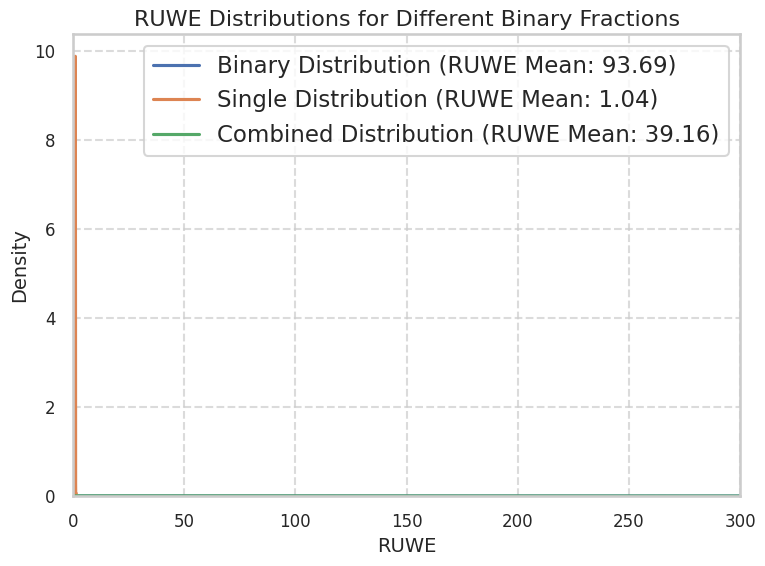

Plot displayed


In [35]:
# Plot only binary stars for different binary fractions
df_list = [df[df['system_type'] == 2.0], df[df['system_type'] == 1.0], df]
titles = ['Binary Distribution', 'Single Distribution', 'Combined Distribution']
plot_ruwe_distributions(df_list, titles)

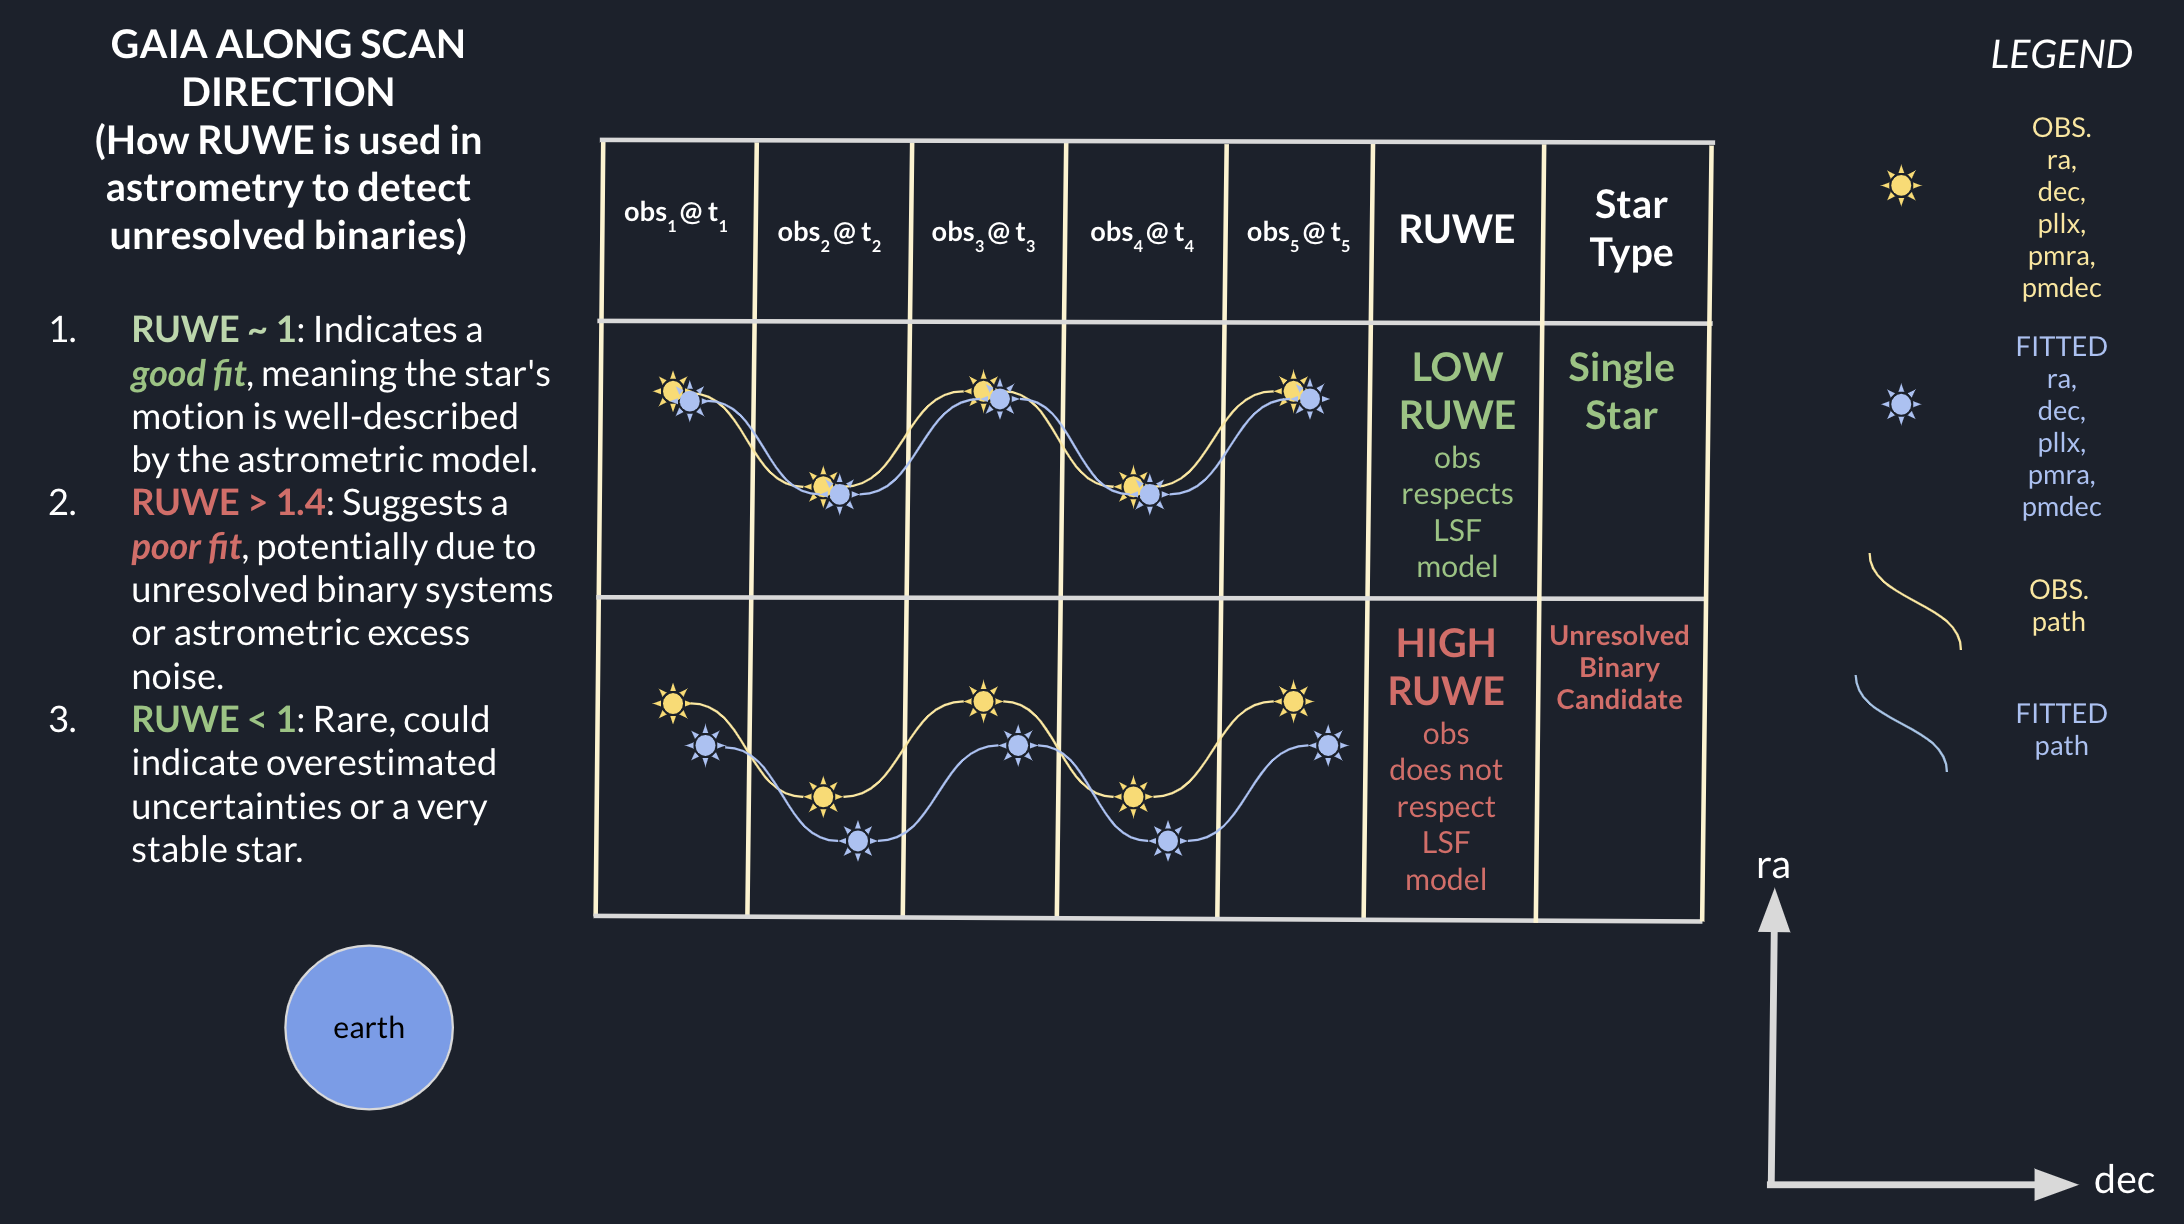

In [5]:
# Display an image from a local file with specified size
img_path = 'images/gaia_ruwe.png'
display(Image(filename=img_path, width=1000, height=800))  # Adjust width and height as needed

Setting the style and context for the plot
Creating the figure and axis objects
Looping over the DataFrames and titles


Plotting distributions: 100%|██████████| 5/5 [00:00<00:00, 45.92it/s]

Plotting KDE for Binary Fraction 0.1
KDE for Binary Fraction 0.1 plotted with mean 8.42
Plotting KDE for Binary Fraction 0.2
KDE for Binary Fraction 0.2 plotted with mean 14.87
Plotting KDE for Binary Fraction 0.3
KDE for Binary Fraction 0.3 plotted with mean 20.58
Plotting KDE for Binary Fraction 0.4
KDE for Binary Fraction 0.4 plotted with mean 34.73
Plotting KDE for Binary Fraction 0.5
KDE for Binary Fraction 0.5 plotted with mean 52.30
Setting the x-axis limits
Setting labels and title
Adding a legend
Customizing the grid
Customizing the ticks
Showing the plot


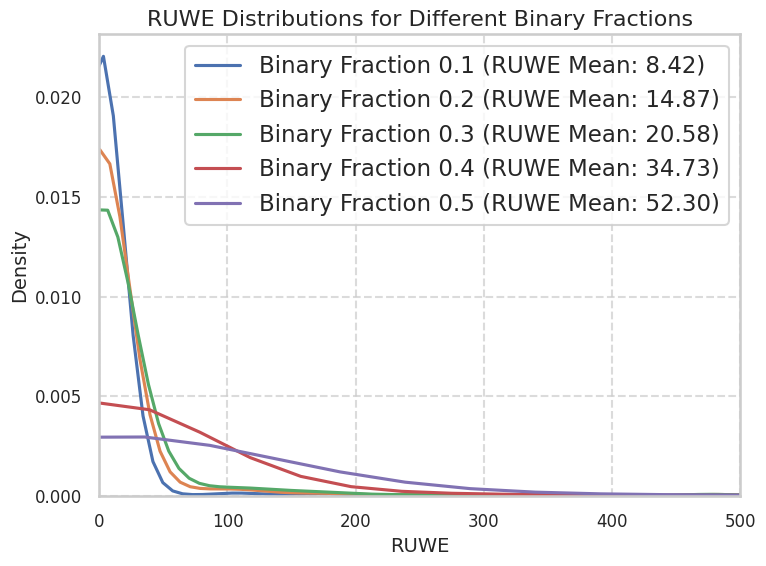

Plot displayed


In [39]:
# Example usage
df_list = [df_0_1, df_0_2, df_0_3, df_0_4, df_0_5]
titles = ['Binary Fraction 0.1', 'Binary Fraction 0.2', 'Binary Fraction 0.3', 'Binary Fraction 0.4', 'Binary Fraction 0.5']
plot_ruwe_distributions(df_list, titles, xlim=(0, 500))

# Plot Luminosity vs Temperature

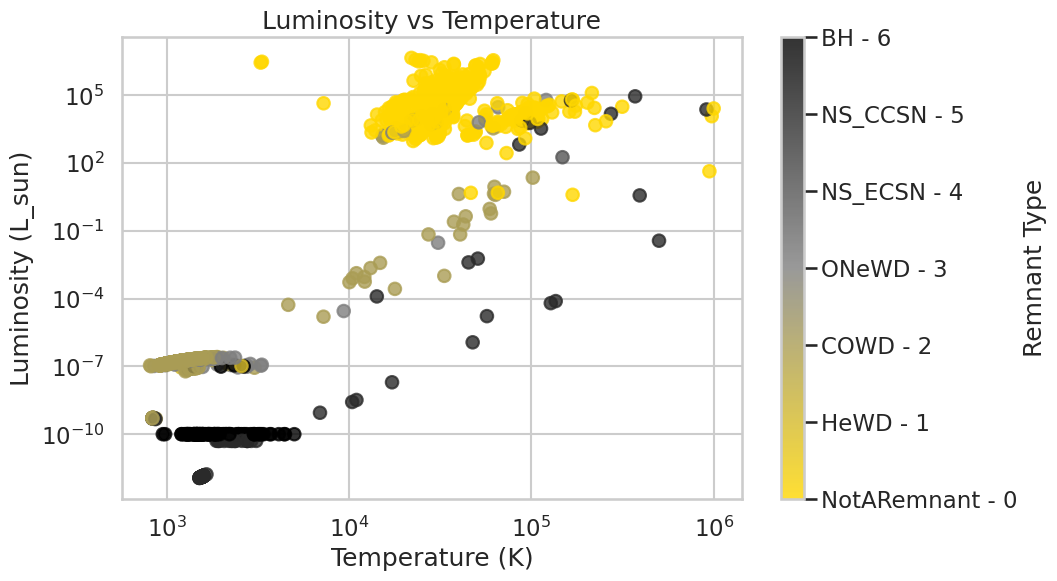

In [40]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

remnant_type = {0: "NotARemnant - 0", 1: "HeWD - 1", 2: "COWD - 2", 3: "ONeWD - 3", 4: "NS_ECSN - 4",
                5: "NS_CCSN - 5", 6: "BH - 6", -1: "Empty - -1"}

# Map the numerical values in RemnantType_0 to their corresponding string values
df['RemnantType_0_str'] = df['RemnantType_0'].map(remnant_type)

# Define a custom colormap from dark yellow to gray to black
colors = ["#FFD700", "#808080", "#000000"]  # Dark yellow, gray, black
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)

# Plot luminosity vs temperature color-coded by RemnantType_0
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Temperature'], df['Luminosity'], c=df['RemnantType_0'], cmap=cmap, alpha=0.8)
plt.xlabel('Temperature (K)')
plt.ylabel('Luminosity (L_sun)')
plt.title('Luminosity vs Temperature')
plt.yscale('log')
plt.xscale('log')

# Create a colorbar with the string labels
cbar = plt.colorbar(scatter, ticks=list(remnant_type.keys()))
cbar.ax.set_yticklabels([remnant_type[key] for key in remnant_type.keys()])
cbar.set_label('Remnant Type')

plt.grid(True)
plt.show()